In [1]:
import dynamiqs as dq
import numpy as np
import jax.numpy as jnp
from pathlib import Path
import pickle
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [24]:
# Define folder path
folder = Path("data/synthetic/state")

# Find all .pkl or .pickle files in the folder
pkl_files = list(folder.glob("*.pkl")) + list(folder.glob("*.pickle"))

# Load all pickle files into a list
data_objects_states = []
file_names_states = []
for file in pkl_files:
    with open(file, "rb") as f:
        obj = pickle.load(f)
        data_objects_states.append(obj)
        file_names_states.append(file.name)

# Define folder path
folder = Path("data/synthetic")

# Find all .pkl or .pickle files in the folder
pkl_files = list(folder.glob("*.pkl")) + list(folder.glob("*.pickle"))

# Load all pickle files and store filenames
data_objects_noisy = []
file_names_noisy = []

for file in pkl_files:
    with open(file, "rb") as f:
        obj = pickle.load(f)
        data_objects_noisy.append(obj)
        file_names_noisy.append(file.name)  # Store just the filename

# Define folder path
folder = Path("data/experimental")

# Find all .pkl or .pickle files in the folder
pkl_files = list(folder.glob("*.pkl")) + list(folder.glob("*.pickle"))

# Load all pickle files into a list
data_objects_experimental = []
file_names_experimental = []
for file in pkl_files:
    with open(file, "rb") as f:
        obj = pickle.load(f)
        data_objects_experimental.append(obj)
        file_names_experimental.append(file.name)


# Ordering of states
order_states = [6,2,7,3,5,1,4,0]
order_noisy = [9,0,11,2,14,6,12,5,15,7,3,10,1,8,4,13]
order_experimental = [0,1,2,3,4,5,6]

data_objects_states = [data_objects_states[i] for i in order_states]
file_names_states = [file_names_states[i] for i in order_states]

data_objects_noisy = [data_objects_noisy[i] for i in order_noisy]
file_names_noisy = [file_names_noisy[i] for i in order_noisy]

data_objects_experimental = [data_objects_experimental[i] for i in order_experimental]
file_names_experimental = [file_names_experimental[i] for i in order_experimental]

wigner = []
for _ in range(len(data_objects_states)):
    wigner.append(dq.wigner(data_objects_states[_],npixels=1000))
states = data_objects_states


In [25]:
def corrected(idx,dataset,sigma,returnPlots=False):
    X,Y,Z = dataset[idx]

    dx, dy = X[1] - X[0], Y[1] - Y[0] 

    z1 = Z[0, :]          
    z2 = Z[-1, :]                       
    z3 = Z[1:-1, 0]             
    z4 = Z[1:-1, 1]                

    # Filter out NaNs
    z1 = z1[~np.isnan(z1)]
    z2 = z2[~np.isnan(z2)]
    z3 = z3[~np.isnan(z3)]
    z4 = z4[~np.isnan(z4)]

    # Concatenate all into one array
    all_edges = np.concatenate([z1, z2, z3, z4])

    # Compute bias
    bias = np.mean(all_edges)

    Z1 = Z-bias
    Z1 = np.nan_to_num(Z1)

    norm = np.sum(Z1) *dy*dx
    Z2 = Z1/np.abs(norm)
    
    return X, Y, Z2

In [26]:
def denoise(idx,dataset,sigma,returnPlots=False):
    X,Y,Z = dataset[idx]
  
    dx, dy = X[1] - X[0], Y[1] - Y[0]

    z1 = Z[0, :]                         
    z2 = Z[-1, :]                        
    z3 = Z[1:-1, 0]                      
    z4 = Z[1:-1, 1]             

    # Filter out NaNs
    z1 = z1[~np.isnan(z1)]
    z2 = z2[~np.isnan(z2)]
    z3 = z3[~np.isnan(z3)]
    z4 = z4[~np.isnan(z4)]

    # Concatenate all into one array
    all_edges = np.concatenate([z1, z2, z3, z4])

    # Compute bias
    bias = np.mean(all_edges)


    Z1 = Z-bias
    Z1 = np.nan_to_num(Z1)

    norm = np.sum(Z1) *dy*dx
    Z2 = Z1/np.abs(norm)
    

    W = Z2  
    # Apply anisotropic Gaussian filter:
    W_smooth = gaussian_filter(W, sigma=sigma)

    if returnPlots==True:
        vmax1 = np.max(np.abs(Z))
        vmax2 = np.max(np.abs(Z2))
        vmax3 = np.max(np.abs(W_smooth))

        fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(15,4))
        im1 = ax1.imshow(Z, origin='lower', aspect='auto', 
                        extent=[Y.min(), Y.max(), X.min(), X.max()],cmap='RdBu_r', vmin=-vmax1, vmax=vmax1)
        ax1.set_title("Original Wigner "+file_names_noisy[idx])
        fig.colorbar(im1, ax=ax1)

        im2 = ax2.imshow(Z2, origin='lower', aspect='auto',
                        extent=[Y.min(), Y.max(), X.min(), X.max()],cmap='RdBu_r', vmin=-vmax2, vmax=vmax2)
        ax2.set_title("Corrected Wigner")
        fig.colorbar(im2, ax=ax2)

        im3 = ax3.imshow(W_smooth, origin='lower', aspect='auto',
                        extent=[Y.min(), Y.max(), X.min(), X.max()],cmap='RdBu_r', vmin=-vmax3, vmax=vmax3)
        ax3.set_title("Smoothed Wigner")
        fig.colorbar(im3, ax=ax3)


        plt.tight_layout()
        plt.show()
        
    return X, Y, W_smooth


In [27]:
def rho(idx,dataset,num_samples,dim_povm,dim_trunc,returnplot=False):
    
   # Initialize lists to hold coarse results
   x_coarse_list = []
   y_coarse_list = []
   W_coarse_list = []
   alpha_sample_list = []

   for x_vec, y_vec, W in dataset:
      # Find valid indices where W is non-zero and non-NaN
      valid_indices = np.logical_and(np.isfinite(W), np.abs(W) > 0.05*np.max(np.abs(W)))

      # Get the (x, y) coordinates corresponding to valid W entries
      valid_x_indices, valid_y_indices = np.where(valid_indices)


      # If there are not enough valid entries, raise an error or handle it gracefully
      if len(valid_x_indices) < num_samples:
         raise ValueError(f"Not enough valid points in W for sampling. Found {len(valid_x_indices)} valid points.")

      # Randomly sample from the valid indices
      sampled_indices = np.random.choice(len(valid_x_indices), size=num_samples, replace=False)

      # Get the corresponding x, y, W values for the sampled indices
      x_coarse = x_vec[valid_x_indices[sampled_indices]]
      y_coarse = y_vec[valid_y_indices[sampled_indices]]
      W_coarse = W[valid_x_indices[sampled_indices], valid_y_indices[sampled_indices]]

      # Construct complex alpha grid
      alpha_sample = x_coarse + 1j * y_coarse

      # Store results
      x_coarse_list.append(x_coarse)
      y_coarse_list.append(y_coarse)
      W_coarse_list.append(W_coarse)
      alpha_sample_list.append(alpha_sample)

   Wk = (W_coarse_list[idx]).reshape(-1)
   wk = 0.5*(1+np.pi/2*Wk)


   alpha = (alpha_sample_list[idx]).reshape(-1)

   dim_full = dim_povm + dim_trunc

   # Generate POVM operators
   parity_full = dq.parity(dim_full)
   identity_full = dq.eye(dim_full, layout=dq.dense)
   D_alpha = dq.displace(dim_full, alpha)
   D_alpha_dag = dq.dag(D_alpha)

   displaced_parity = D_alpha @ parity_full @ D_alpha_dag
   povm_full = 0.5 * (identity_full + displaced_parity)

   
   # Truncate POVM into desired shape
   povm_truncated_data = povm_full.data[:, :dim_povm, :dim_povm]

   povm_np = povm_truncated_data
   
   # Define CVXPY variable
   rho = cp.Variable((dim_povm, dim_povm), hermitian=True)

   # Constraints: rho is PSD and has trace 1
   constraints = [rho >> 0, cp.trace(rho) == 1]

   wk_vec = np.array(wk)

   # Vectorized list of predicted values: Tr(E_i * rho) for each POVM element
   preds = cp.hstack([cp.real(cp.trace(P@rho)) for P in povm_np]) 

   #  Define least-squares objective
   objective = cp.Minimize(cp.sum_squares(preds - wk_vec))

   # Solve the problem
   problem = cp.Problem(objective, constraints)
   problem.solve(solver=cp.SCS)

   # Extract solution
   rho_opt = rho.value

   X ,Y,Z = dataset[idx]
   if returnplot ==True:

      vmax1 = np.max(np.abs(Z))
      vmax2 = 2/np.pi

      X1,Y1,Z1 = dq.wigner(rho_opt,npixels=1000)
      

      fig, (ax1, ax2 ) = plt.subplots(1,2, figsize=(15,4))
      im1 = ax1.imshow(Z, origin='lower', aspect='auto', 
                        extent=[Y.min(), Y.max(), X.min(), X.max()],cmap='RdBu_r', vmin=-vmax1, vmax=vmax1)
      ax1.set_title("Smoothed Wigner "+file_names_noisy[idx])
      ax1.set_xlabel('p')
      ax1.set_ylabel('x')
      fig.colorbar(im1, ax=ax1,label='Wigner Value')
      
      im2 = ax2.imshow(Z1, origin='lower', aspect='auto',
                        extent=[Y1.min(), Y1.max(), X1.min(), X1.max()],cmap='RdBu_r', vmin=-vmax2, vmax=vmax2)
      ax2.set_title("Fitted Wigner")
      ax2.set_xlabel('p')
      ax2.set_ylabel('x')
      fig.colorbar(im2, ax=ax2,label='Wigner Value')
      

      plt.tight_layout()
      plt.show()
      
   return rho_opt

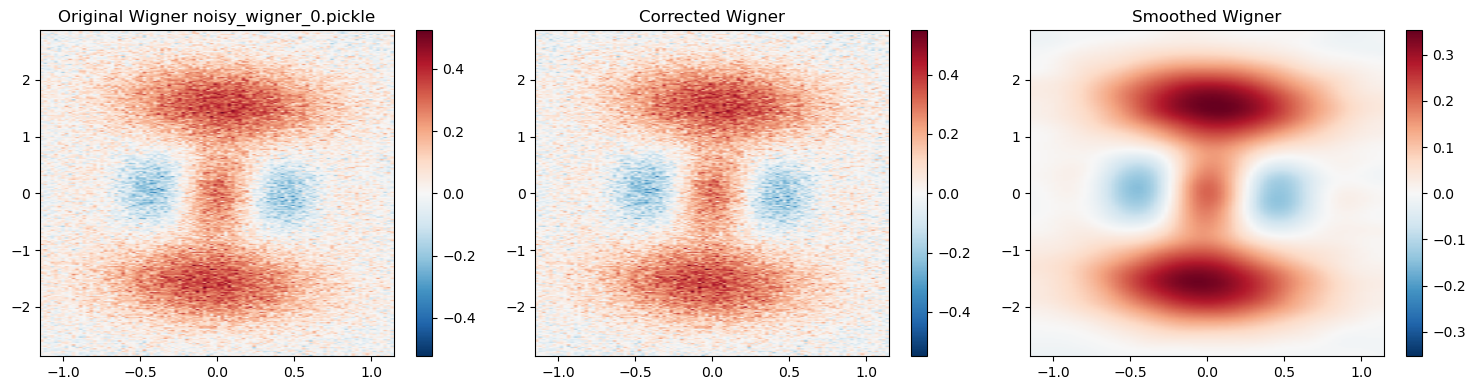

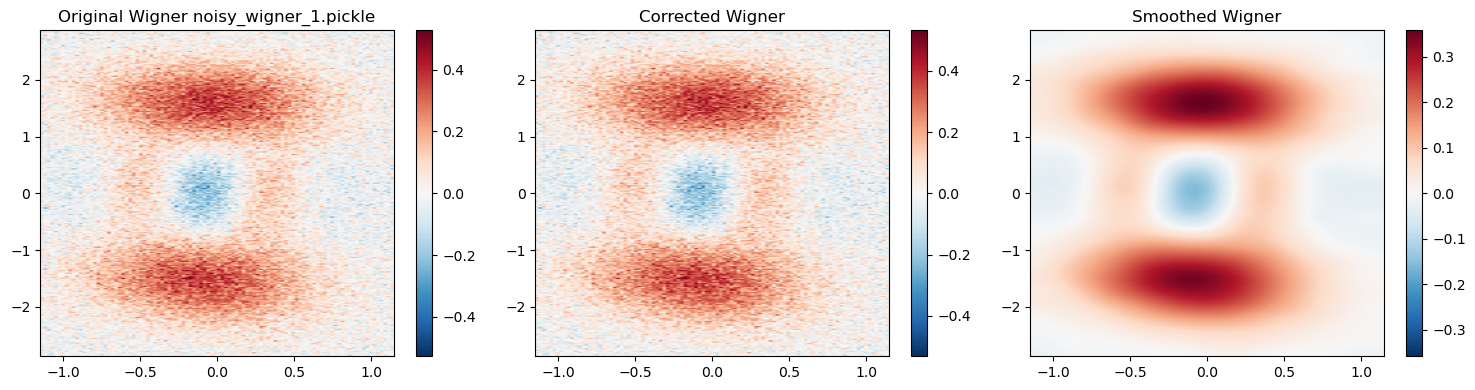

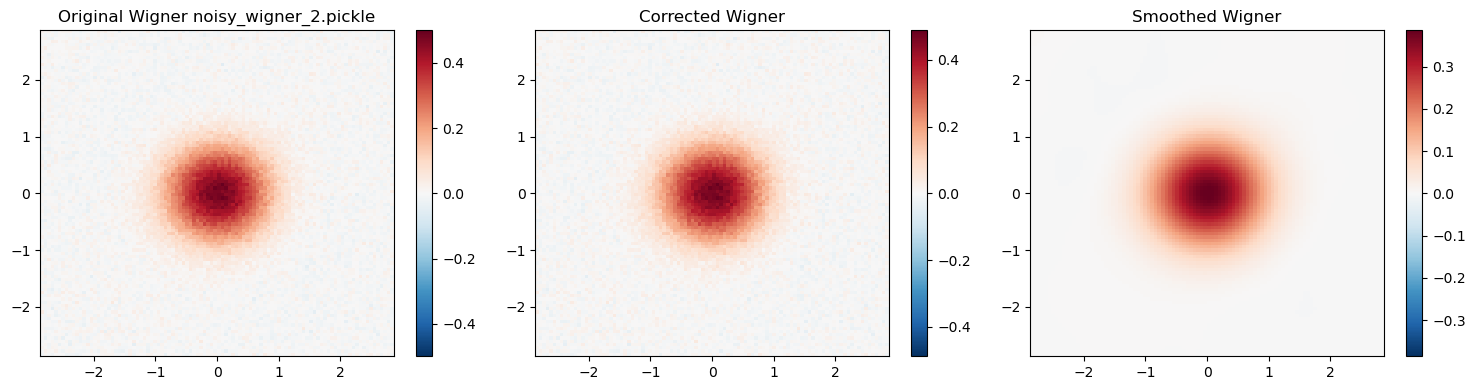

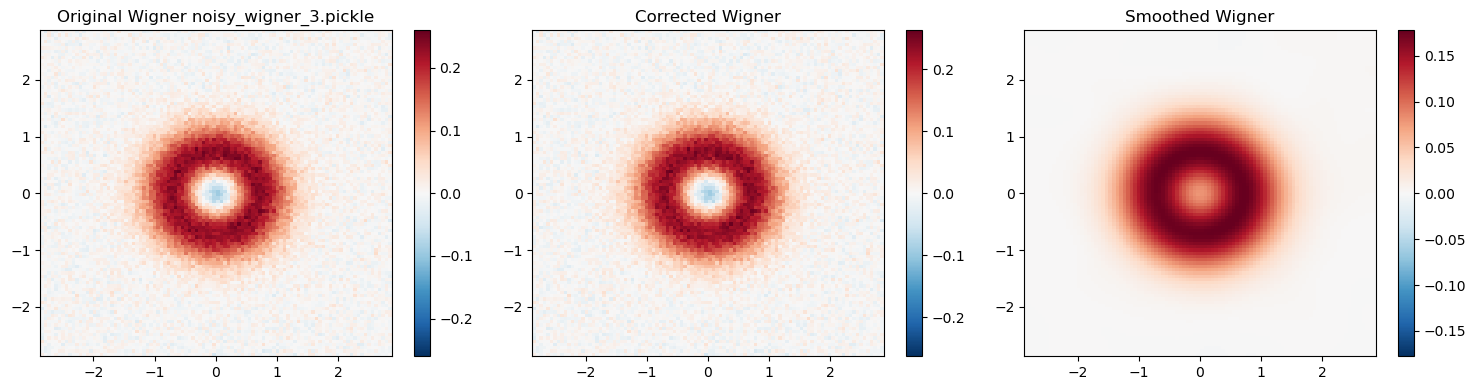

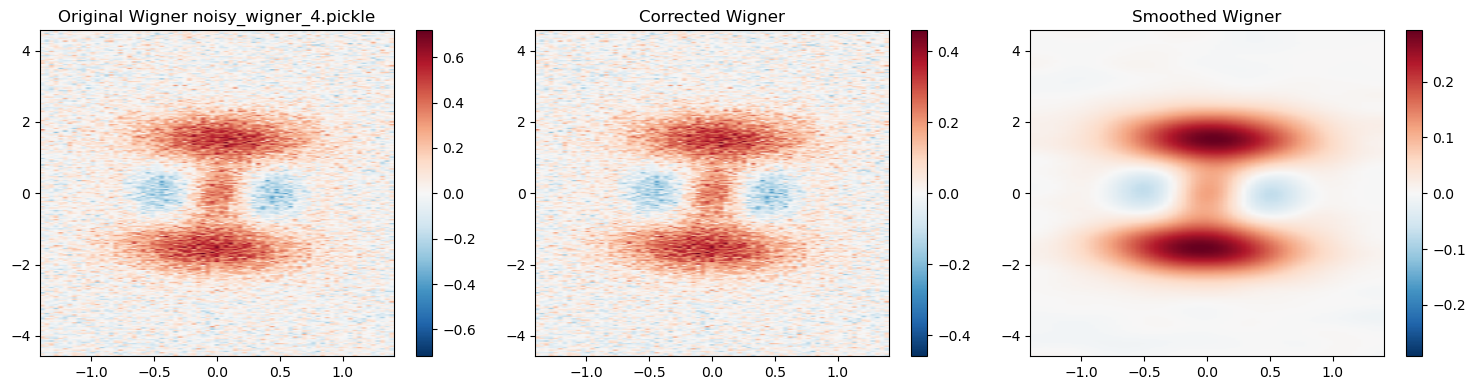

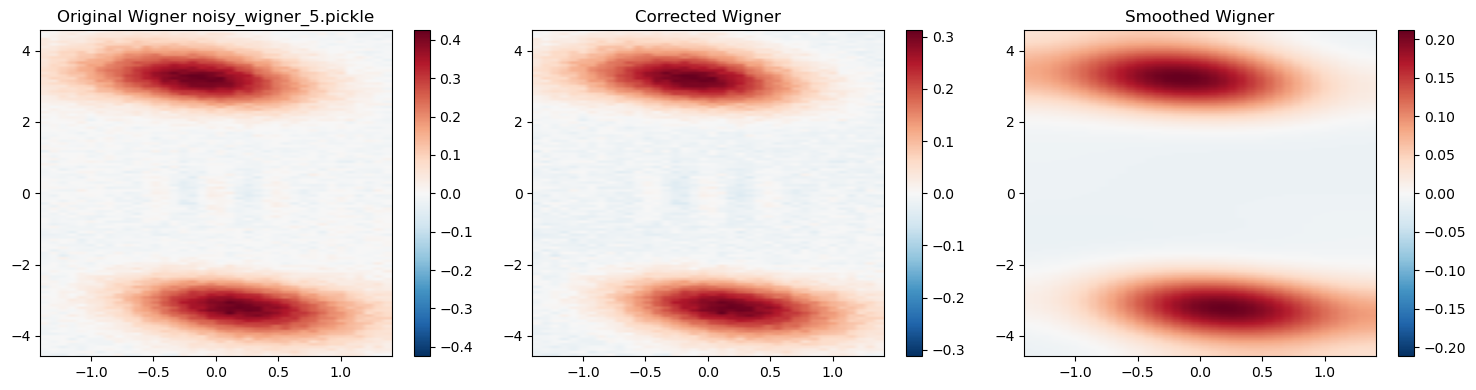

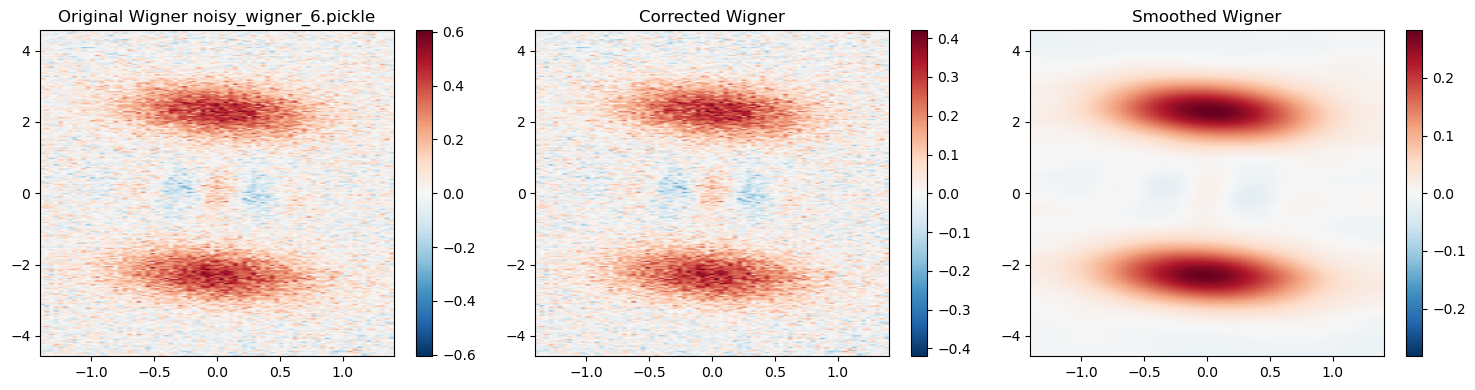

In [30]:
sigma = 5
dataset = data_objects_experimental

clean_dataset_experimental = []
for i in range((7)):
    clean_dataset_experimental.append(denoise(i, dataset, sigma,returnPlots=True))


corrected_dataset_experimental = []
for i in range((7)):
    corrected_dataset_experimental.append(corrected(i, dataset, sigma))

In [20]:
num_samples = 1000
dim_povm = 50
dim_trunc=30

clean_rho_experimental = []
for i in range (7):
    clean_rho_experimental.append(rho(i, clean_dataset_experimental, num_samples, dim_povm, dim_trunc,returnplot=False))


raw_rho_experimental = []
for i in range (7):
    raw_rho_experimental.append(rho(i, corrected_dataset_experimental, num_samples, dim_povm, dim_trunc,returnplot=False))

/Users/finnmuessigbrodt/miniforge3/envs/myenv/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/Users/finnmuessigbrodt/miniforge3/envs/myenv/lib/python3.11/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


In [21]:
def compareFidelity(rho_dataset, rho_ref):
    N = len(rho_dataset)
    fidelities = []
    for i in range(N):
        fidelities.append(dq.fidelity(rho_dataset[i],rho_ref[i]))
    return fidelities


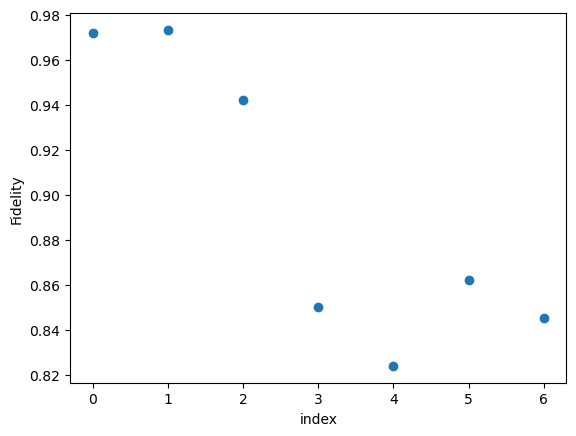

In [31]:

F1 = np.array(compareFidelity(clean_rho_experimental,raw_rho_experimental))

plt.figure()
plt.scatter(np.arange(7),F1)
plt.ylabel('Fidelity')
plt.xlabel('index')
plt.show()

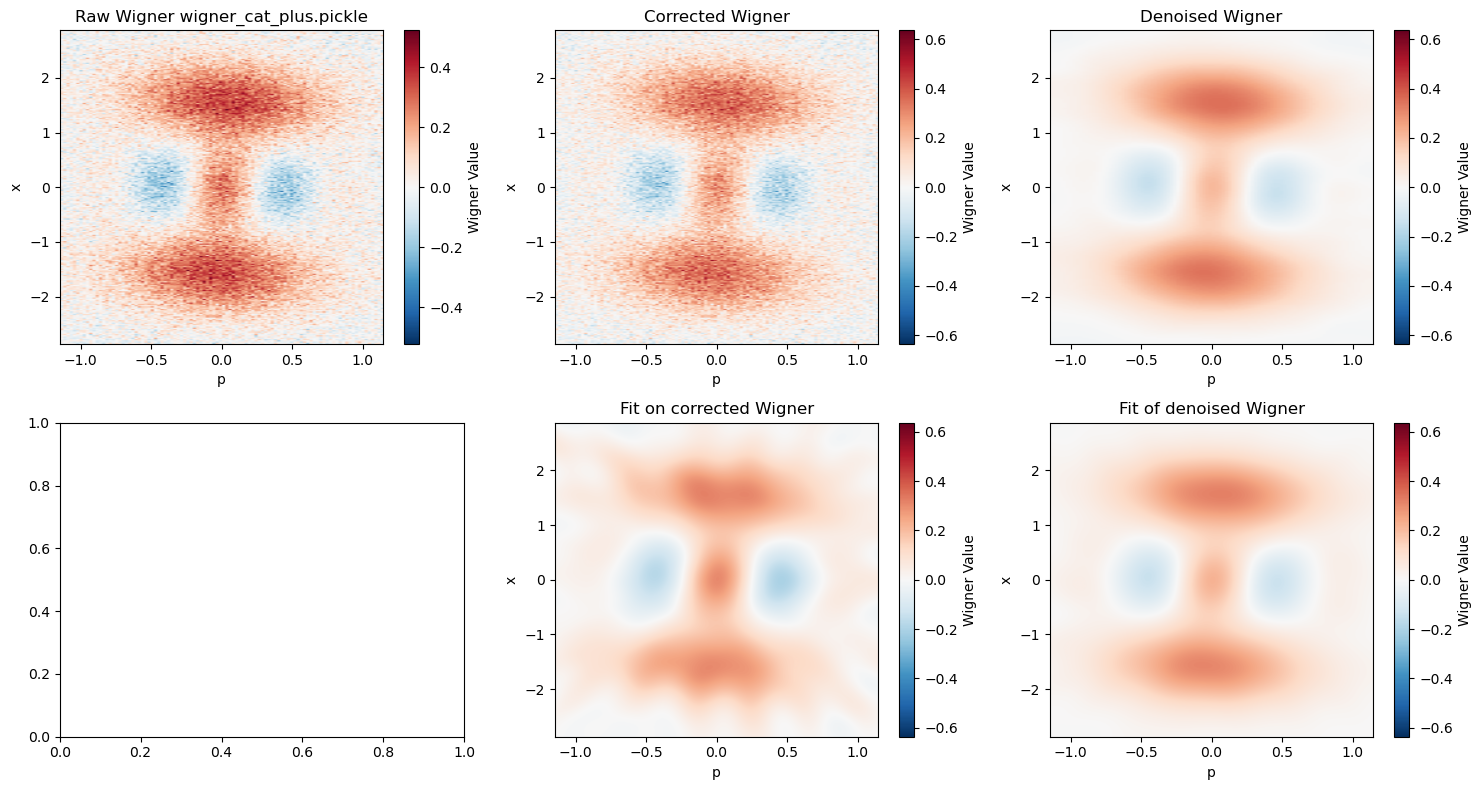

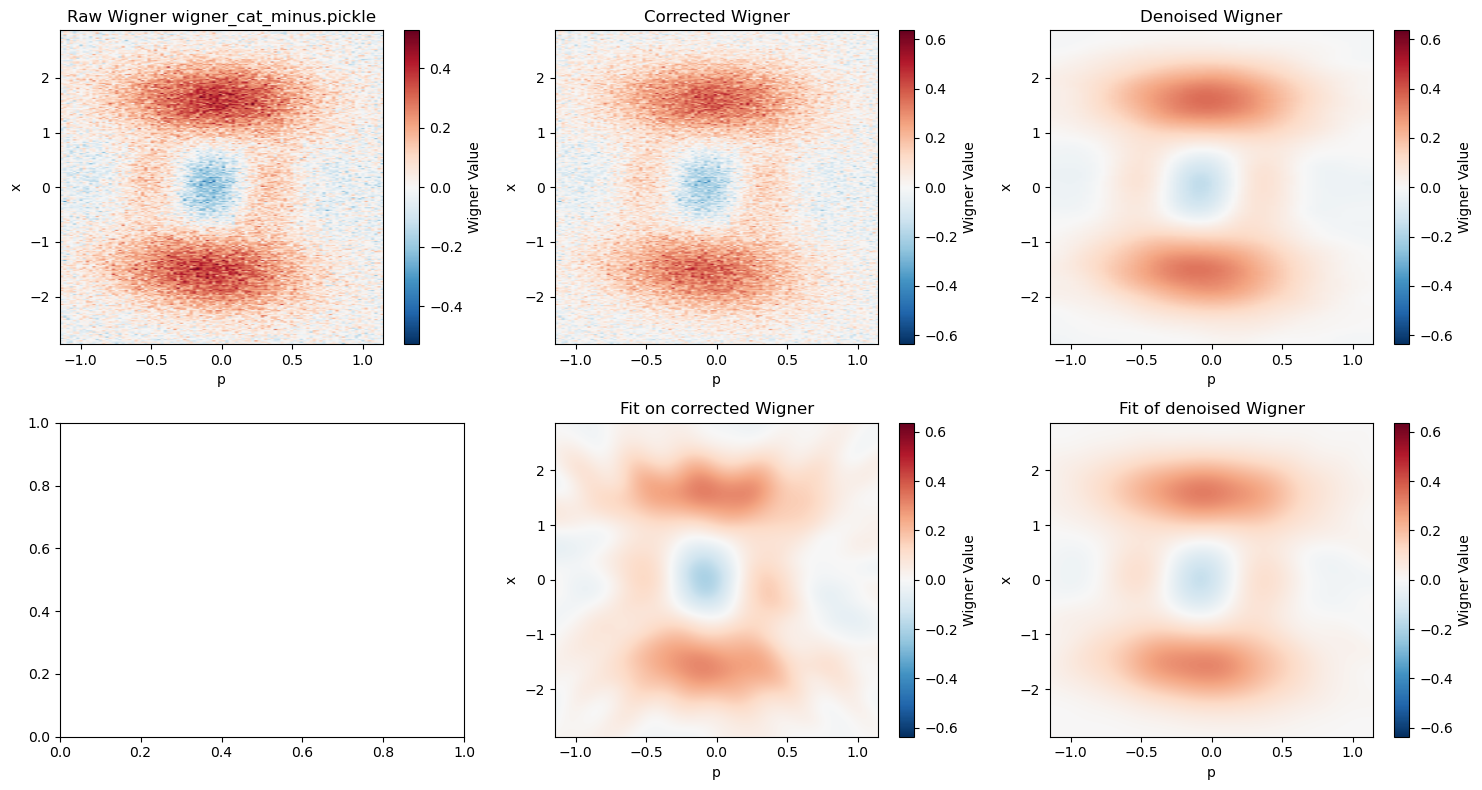

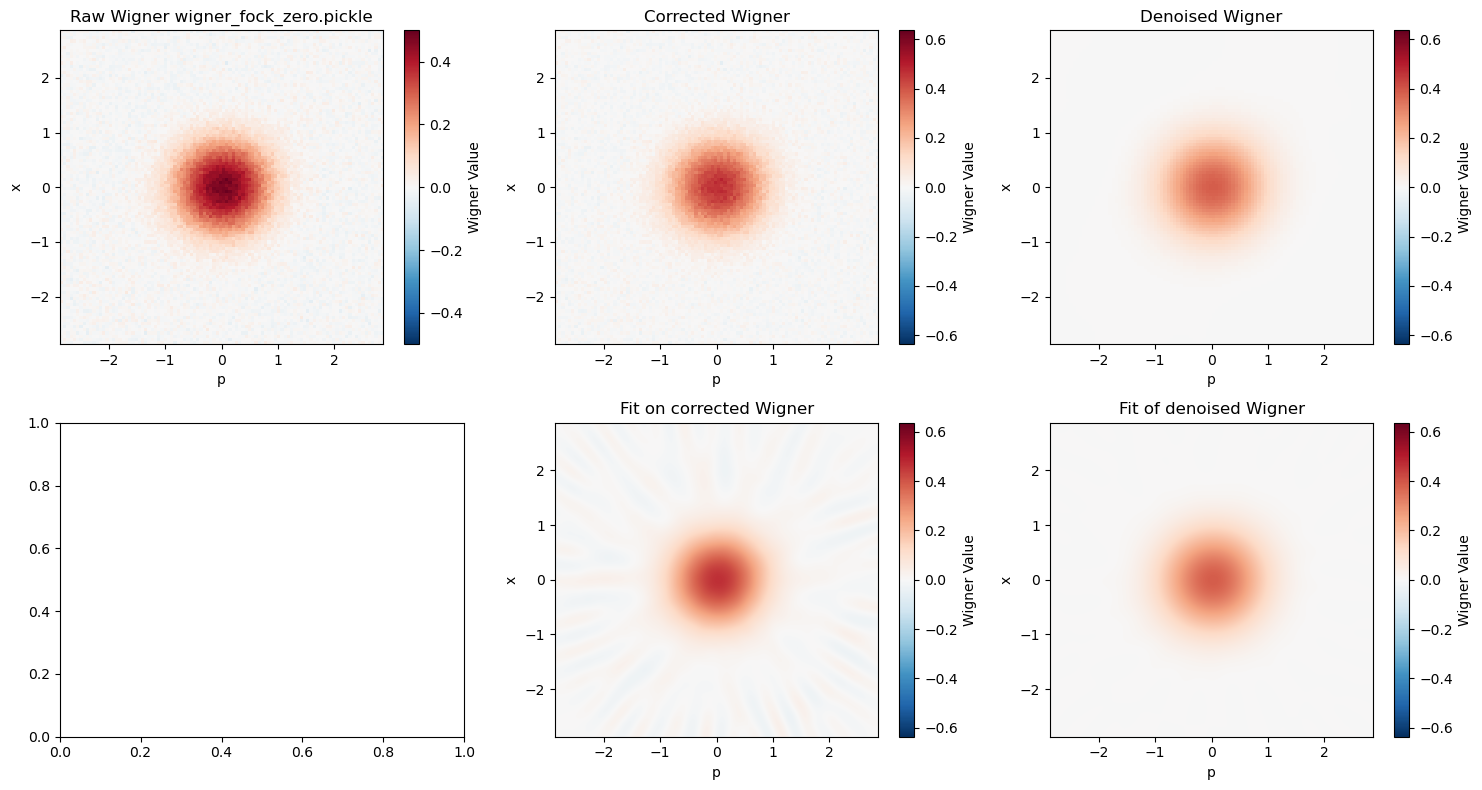

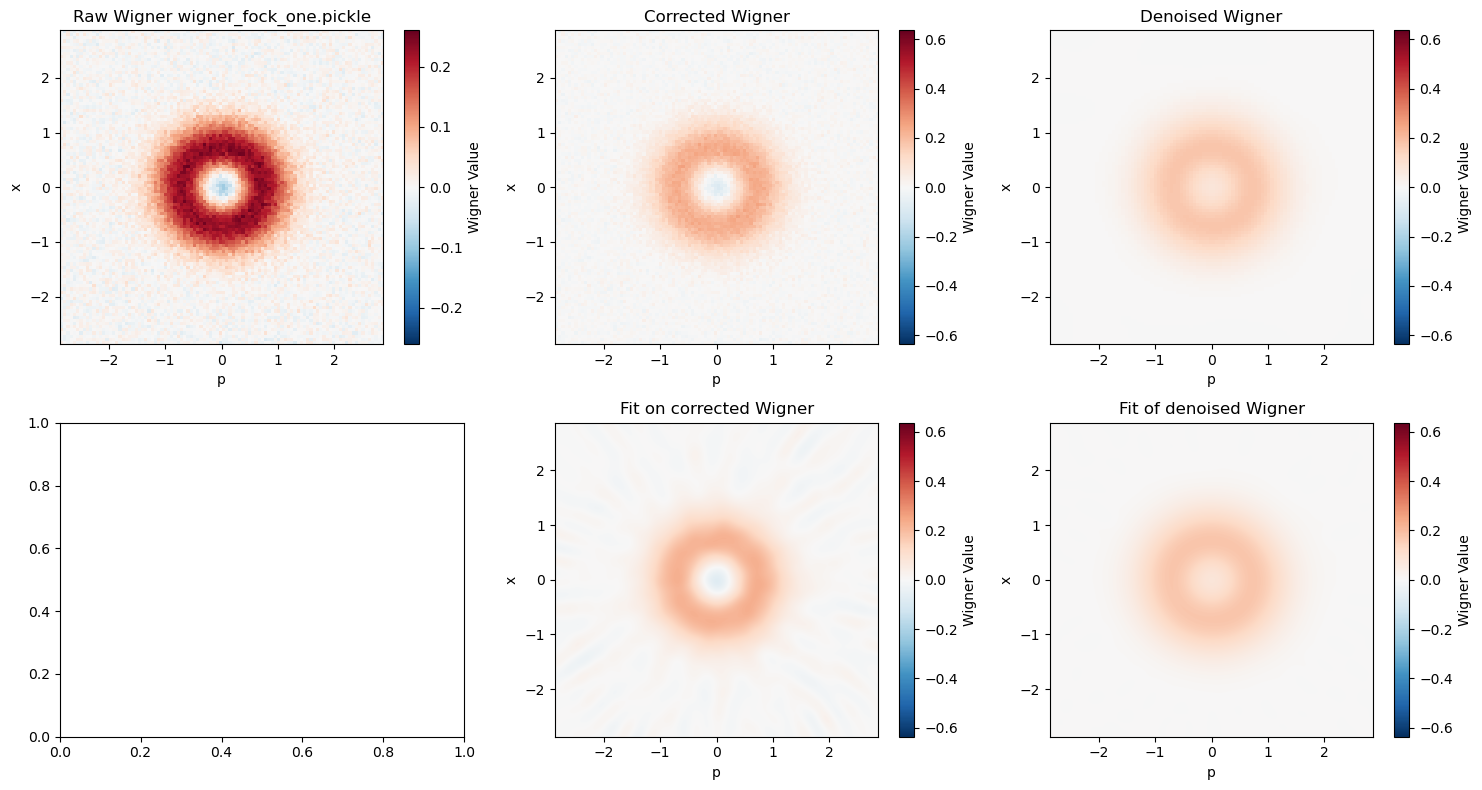

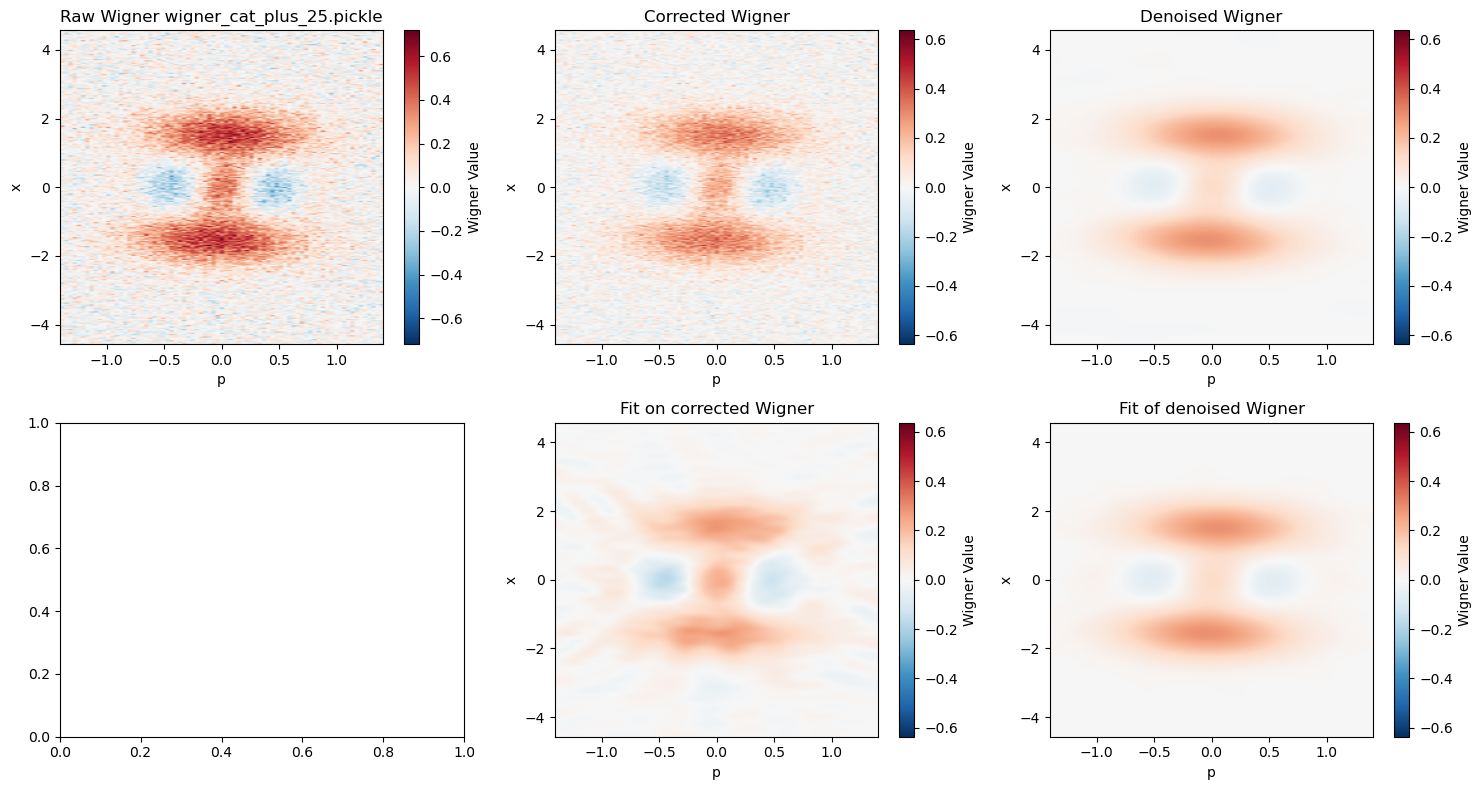

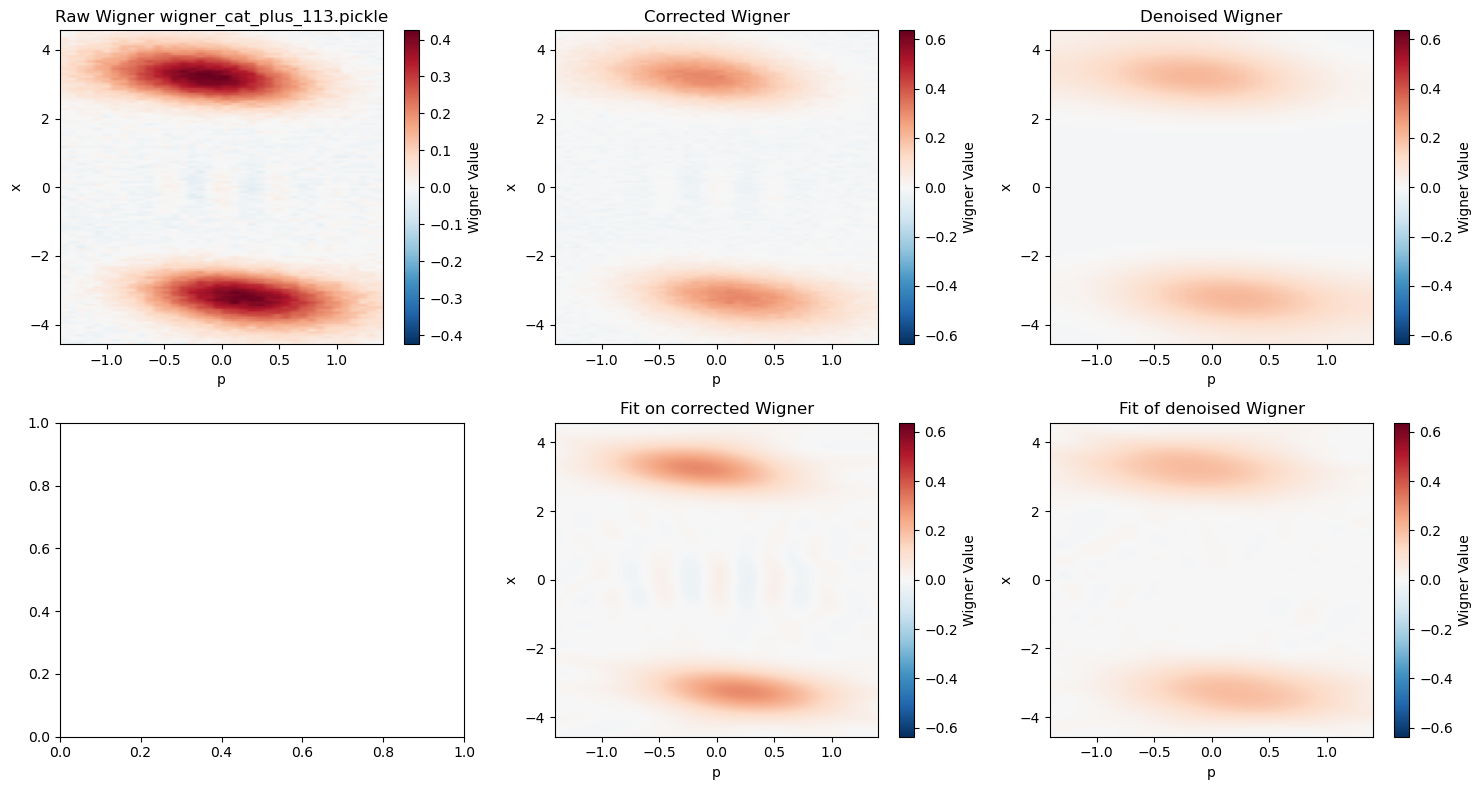

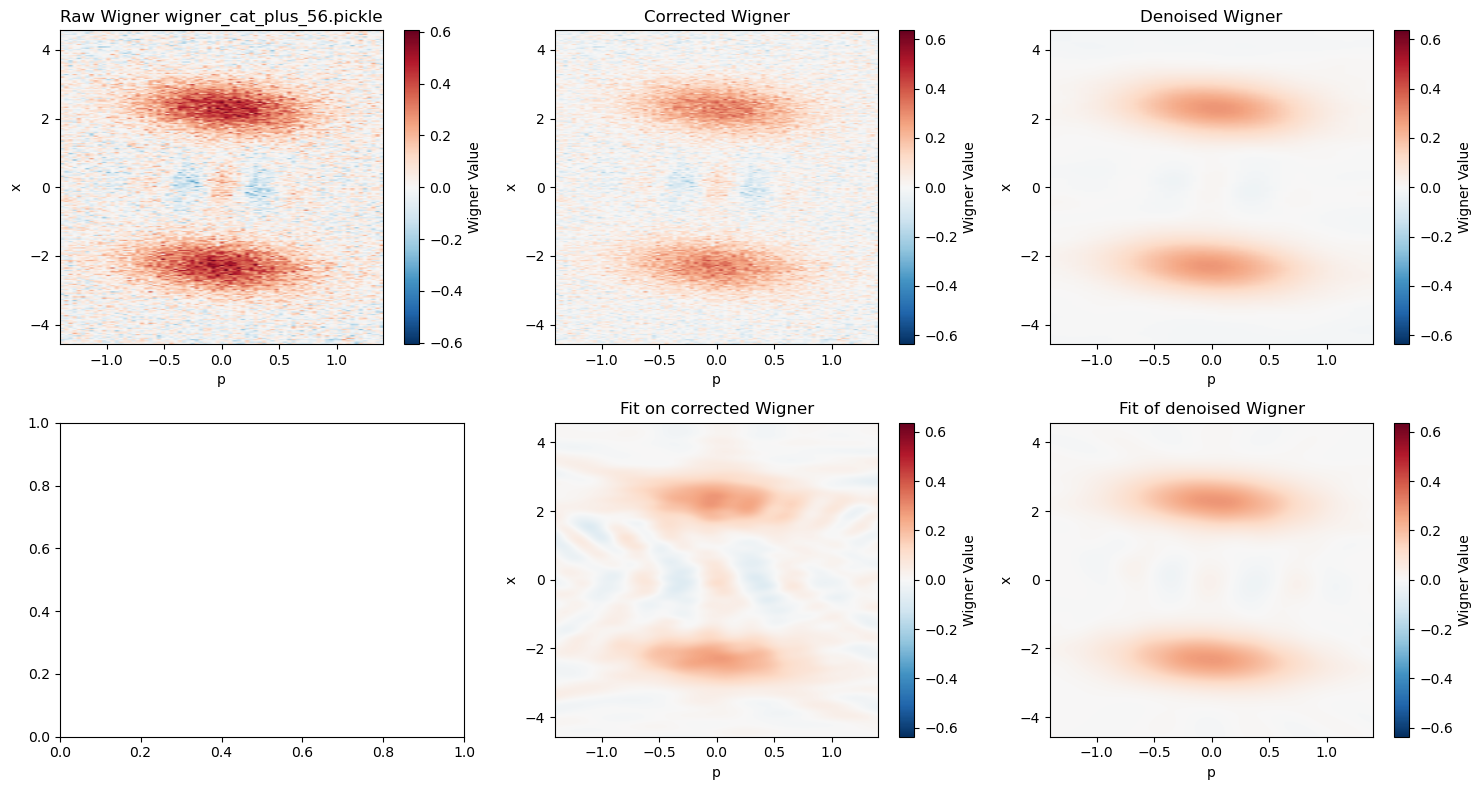

In [ ]:
for i in range(7):
    
    X1 ,Y1,Z1 = data_objects_experimental[i]
    X2,Y2,Z2 = corrected_dataset_experimental[i]
    X3,Y3,Z3 = clean_dataset_experimental[i]

    xmax=np.max(X1)
    ymax=np.max(Y1)

    X5,Y5,Z5 = dq.wigner(raw_rho_experimental[i],npixels=1000,xmax =xmax,ymax=ymax)
    X6,Y6,Z6 = dq.wigner(clean_rho_experimental[i],npixels=1000,xmax =xmax,ymax=ymax)

    vmax1 = np.max(np.abs(Z1))
    vmax2 = 2/np.pi
    vmax3 = 2/np.pi
    vmax5 = 2/np.pi
    vmax6 = 2/np.pi

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    ax1 = axes[0, 0]
    ax2 = axes[0, 1]
    ax3 = axes[0, 2]
    ax4 = axes[1, 0]
    ax5 = axes[1, 1]
    ax6 = axes[1, 2]

    im1 = ax1.imshow(Z1, origin='lower', aspect='auto', 
                    extent=[Y1.min(), Y1.max(), X1.min(), X1.max()],cmap='RdBu_r', vmin=-vmax1, vmax=vmax1)
    ax1.set_title("Raw Wigner "+file_names_experimental[i])
    ax1.set_xlabel('p')
    ax1.set_ylabel('x')
    fig.colorbar(im1, ax=ax1,label='Wigner Value')

    im2 = ax2.imshow(Z2, origin='lower', aspect='auto',
                    extent=[Y2.min(), Y2.max(), X2.min(), X2.max()],cmap='RdBu_r', vmin=-vmax2, vmax=vmax2)
    ax2.set_title("Corrected Wigner")
    ax2.set_xlabel('p')
    ax2.set_ylabel('x')
    fig.colorbar(im2, ax=ax2,label='Wigner Value')

    im3 = ax3.imshow(Z3, origin='lower', aspect='auto', 
                    extent=[Y3.min(), Y3.max(), X3.min(), X3.max()],cmap='RdBu_r', vmin=-vmax3, vmax=vmax3)
    ax3.set_title("Denoised Wigner")
    ax3.set_xlabel('p')
    ax3.set_ylabel('x')
    fig.colorbar(im3, ax=ax3,label='Wigner Value')

    im5 = ax5.imshow(Z5, origin='lower', aspect='auto',
                    extent=[Y5.min(), Y5.max(), X5.min(), X5.max()],cmap='RdBu_r', vmin=-vmax5, vmax=vmax5)
    ax5.set_title("Fit on corrected Wigner")
    ax5.set_xlabel('p')
    ax5.set_ylabel('x')
    fig.colorbar(im5, ax=ax5,label='Wigner Value')

    im6 = ax6.imshow(Z6, origin='lower', aspect='auto', 
                    extent=[Y6.min(), Y6.max(), X6.min(), X6.max()],cmap='RdBu_r', vmin=-vmax6, vmax=vmax6)
    ax6.set_title("Fit of denoised Wigner")
    ax6.set_xlabel('p')
    ax6.set_ylabel('x')
    fig.colorbar(im6, ax=ax6,label='Wigner Value')

    plt.tight_layout()
    plt.show()